### Route metrics
- Total number of stops per route
- Planned total distance per route (sum of DistanceP)
- Actual total distance per route (sum of DistanceA)
- Distance deviation per route (actual total distance minus planned total distance)
- Distance efficiency ratio per route (actual total distance divided by planned total distance)
- Number of sequence deviations per route (count of stops where IndexP is not equal to IndexA)
- Deviation rate per route (sequence deviations divided by total stops)
- Number of SLA violations per route (count of stops where Arrived Time is greater than Latest Time)
- SLA violation rate per route (SLA violations divided by total stops)
- Total route duration per route (maximum Arrived Time minus minimum Arrived Time)


In [1]:
import pandas as pd
import numpy as np

In [2]:
df=pd.read_csv(r'D:\Coding\last-mile-route-deviation-analytics\data\raw\routes_performance.csv')

In [3]:
df.head()

,Route ID,Driver ID,Stop ID,Address ID,Week ID,Country,Day of Week,IndexP,IndexA,Arrived Time,Earliest Time,Latest Time,DistanceP,DistanceA,Depot,Delivery
0,0,0,0,0,0,1,Monday,0,0,42.275,0.0,360.0,0.000000,0.000000,1,0
1,0,0,1,1,0,1,Tuesday,1,4,332.788,240.0,480.0,16.329053,16.329053,0,1
2,0,0,2,2,0,1,Tuesday,2,5,332.956,120.0,540.0,0.373110,0.373110,0,1
3,0,0,3,3,0,1,Monday,3,2,244.994,60.0,540.0,2.491915,0.000000,0,1
4,0,0,4,3,0,1,Monday,4,1,244.855,60.0,540.0,0.000000,13.944962,0,1


In [4]:
df['sla_violation']=df['Arrived Time']>df['Latest Time']
df["sequence_deviation"] = df["IndexP"] != df["IndexA"]

In [5]:
route_metrics = (
    df
    .groupby('Route ID')
    .agg(
        total_stops=('Stop ID','count'),
        planned_distance=('DistanceP','sum'),
        actual_distance=('DistanceA','sum'),
        deviation_count=('sequence_deviation','sum'),
        sla_violation_count=('sla_violation','sum'),
        route_start_time=('Arrived Time','min'),
        route_end_time=('Arrived Time','max')
    )
    .reset_index()
)

route_metrics['distance_deviation'] = (
    route_metrics['actual_distance'] - route_metrics['planned_distance']
)

route_metrics['distance_efficiency_ratio'] = (
    route_metrics['actual_distance'] / route_metrics['planned_distance']
)

route_metrics['route_duration'] = (
    route_metrics['route_end_time'] - route_metrics['route_start_time']
)

route_metrics['sla_violation_rate'] = (
    route_metrics['sla_violation_count'] / route_metrics['total_stops']
)

route_metrics['deviation_rate'] = (
    route_metrics['deviation_count'] / route_metrics['total_stops']
)


In [6]:
route_metrics

,Route ID,total_stops,planned_distance,actual_distance,deviation_count,sla_violation_count,route_start_time,route_end_time,distance_deviation,distance_efficiency_ratio,route_duration,sla_violation_rate,deviation_rate
0,0,7,49.468094,44.965197,5,0,42.275,373.553,-4.502897,0.908974,331.278,0.000000,0.714286
1,1,7,33.274342,33.610418,6,0,64.855,371.387,0.336076,1.010100,306.532,0.000000,0.857143
2,2,7,12.124804,12.508786,4,0,110.283,473.273,0.383982,1.031669,362.990,0.000000,0.571429
3,3,10,19.039848,19.374644,6,0,194.274,448.366,0.334795,1.017584,254.092,0.000000,0.600000
4,4,8,20.632674,19.528799,2,0,196.588,357.340,-1.103875,0.946499,160.752,0.000000,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19642,19642,11,87.649605,87.649605,0,0,105.793,492.654,0.000000,1.000000,386.861,0.000000,0.000000
19643,19643,11,57.576218,50.429013,5,0,46.825,396.873,-7.147205,0.875865,350.048,0.000000,0.454545
19644,19644,7,99.832525,99.832525,0,2,49.419,436.213,0.000000,1.000000,386.794,0.285714,0.000000
19645,19645,10,27.611547,27.719758,2,1,87.231,427.429,0.108212,1.003919,340.198,0.100000,0.200000


### Sanity Checks

In [7]:
route_metrics['Route ID'].is_unique

True

In [8]:
# row count check

total_rows = df.shape[0]
total_routes = route_metrics.shape[0]

total_rows, total_routes


(249231, 19647)

In [9]:
# non negative distances

(route_metrics['planned_distance']<0).sum() , (route_metrics['actual_distance']<0).sum()

(np.int64(0), np.int64(0))

In [10]:
# check for NaN or infinity
route_metrics.isna().sum(), \
np.isinf(route_metrics['distance_efficiency_ratio']).sum()

(Route ID                     0
 total_stops                  0
 planned_distance             0
 actual_distance              0
 deviation_count              0
 sla_violation_count          0
 route_start_time             0
 route_end_time               0
 distance_deviation           0
 distance_efficiency_ratio    1
 route_duration               0
 sla_violation_rate           0
 deviation_rate               0
 dtype: int64,
 np.int64(0))

In [11]:
# deviation bound check
(route_metrics["deviation_count"] > route_metrics["total_stops"]).sum()

np.int64(0)

In [12]:
#SLA bound check
(route_metrics["sla_violation_count"] > route_metrics["total_stops"]).sum()

np.int64(0)

In [13]:
# route duration check
(route_metrics['route_duration']<0).sum()

np.int64(0)

In [14]:
route_metrics.describe()


,Route ID,total_stops,planned_distance,actual_distance,deviation_count,sla_violation_count,route_start_time,route_end_time,distance_deviation,distance_efficiency_ratio,route_duration,sla_violation_rate,deviation_rate
count,19647.000000,19647.000000,19647.000000,19647.000000,19647.000000,19647.000000,1.964700e+04,1.964700e+04,19647.000000,19646.000000,19647.000000,19647.000000,19647.000000
mean,9823.000000,12.685448,64.160508,63.199997,6.327175,1.291189,1.508296e+03,1.960068e+03,-0.960511,0.998766,451.772815,0.102011,0.440783
std,5671.744705,5.566924,68.117164,71.166229,5.639303,2.264176,1.182611e+05,1.182896e+05,22.444547,0.190920,1351.406029,0.180803,0.317220
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-507.106885,0.141538,0.000000,0.000000,0.000000
25%,4911.500000,8.000000,29.861861,29.204916,2.000000,0.000000,1.439620e+02,4.670360e+02,-1.115260,0.972524,267.278000,0.000000,0.133333
50%,9823.000000,12.000000,50.079076,49.029368,5.000000,0.000000,2.037600e+02,5.625850e+02,0.000000,1.000000,354.163000,0.000000,0.500000
75%,14734.500000,17.000000,80.855897,79.364024,10.000000,2.000000,2.661020e+02,6.657215e+02,0.632074,1.016210,444.045000,0.133333,0.722222
max,19646.000000,36.000000,1948.653027,2409.824486,33.000000,28.000000,1.280999e+07,1.281432e+07,1898.701726,6.227439,57552.851000,1.000000,1.000000


### Dataset Overview
- Total Rows: 249,231 stops.

- Total Routes: 19,647 unique routes.

### Data Quality
- Distances: All distance values are positive or zero. There are no negative distances.

- Efficiency Ratio: Only one missing value (NaN) exists. There are no infinity errors.

- Route Duration: All durations are valid. There are no values less than zero.

### Data Sanity Checks
#### Logic Verification

- Deviation Counts: The number of deviations is never higher than the total stops in a route. This confirms the deviation logic is correct.

- SLA Violations: The number of SLA breaches never exceeds the total stops per route. This validates the SLA logic.

#### Edge Cases

- Distance Discrepancies: Some routes have zero planned distance but show positive actual distance. These are flagged as edge cases.

- Missing Ratios (NaN): One NaN exists because the planned distance was zero. This will be addressed during the visualization step.

### EDA Interpretation

1. Deviation Frequency Route deviations are very common. Most drivers change the stop sequence instead of following the computer's plan exactly.

2. Deviation vs. Distance Changing the sequence does not always increase the distance. In many cases, drivers who deviate actually end up driving fewer miles than planned.

3. Distance vs. SLA Risk Extra miles and late deliveries are linked, but distance isn't the only problem. Some routes have late deliveries (SLA violations) even when the driver follows the exact planned distance.

4. Driver Distribution Efficiency is not the same for everyone. A small number of routes show very high distance loss, suggesting that a few drivers or specific areas cause most of the waste.

5. Positive Deviations There are many "human wins." In several routes, the driver's actual path was shorter than the software's planned path. This points to flaws in the original route planning.

## Visual EDA ->

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0, 0.5, 'Frequency')

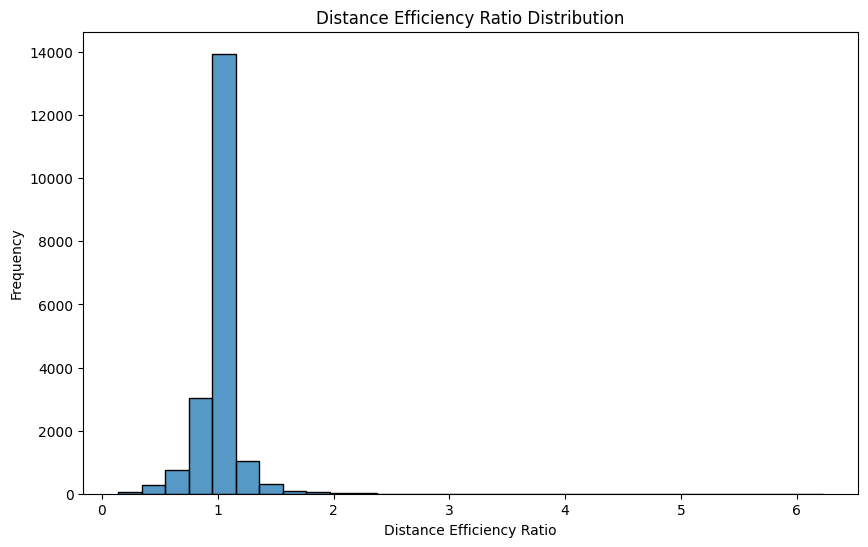

In [33]:
# Distance Efficiency Distribution
plt.figure(figsize=(10,6))
sns.histplot(route_metrics['distance_efficiency_ratio'], bins=30)
plt.title('Distance Efficiency Ratio Distribution')
plt.xlabel('Distance Efficiency Ratio')
plt.ylabel('Frequency')

Most routes are efficient. The highest peak is at 1.0, where about 14,000 routes are located.

The data is skewed. Most values fall between 0.5 and 1.5, but a few go as high as 6.0.

Outliers exist. Values above 2.0 represent very inefficient routes that may need investigation.

Most routes follow the plan closely. However, a few routes are very inefficient. These few routes cause most of the extra costs and should be fixed first.

Text(0.5, 1.0, 'Deviation Rate vs Distance Deviation')

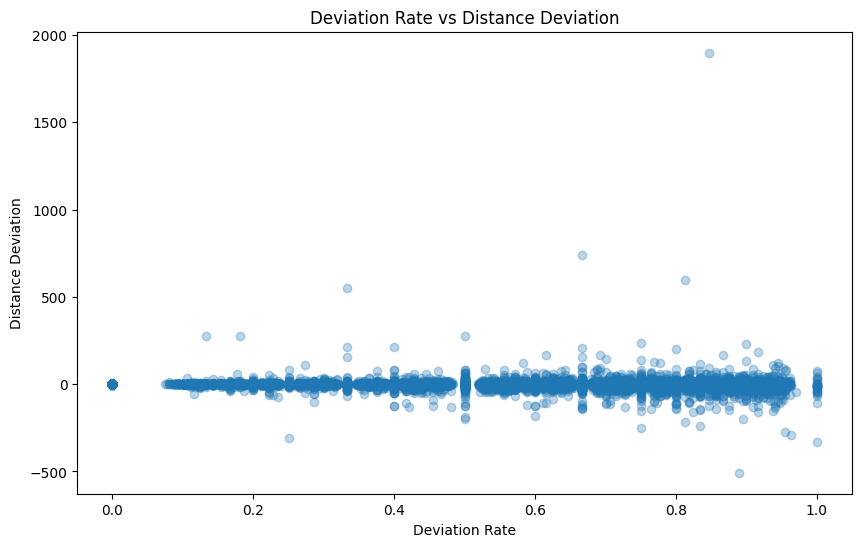

In [34]:
# Deviation Rate vs Distance Deviation.
plt.figure(figsize=(10,6))
plt.scatter(route_metrics['deviation_rate'],route_metrics['distance_deviation'],alpha=0.3)
plt.xlabel('Deviation Rate')
plt.ylabel('Distance Deviation')
plt.title('Deviation Rate vs Distance Deviation')

- Most drivers change their sequence without adding miles. Changing the plan usually does not hurt efficiency.

- High deviation makes results unpredictable. When drivers change the plan too much, it can occasionally lead to very high costs.

- Deviation is not always bad. Most changes are harmless, but a few cause extreme waste.

- Targeted review is best. The company should only investigate the extreme cases instead of banning all route changes

Text(0.5, 1.0, 'SLA Violation Rate vs Distance Deviation')

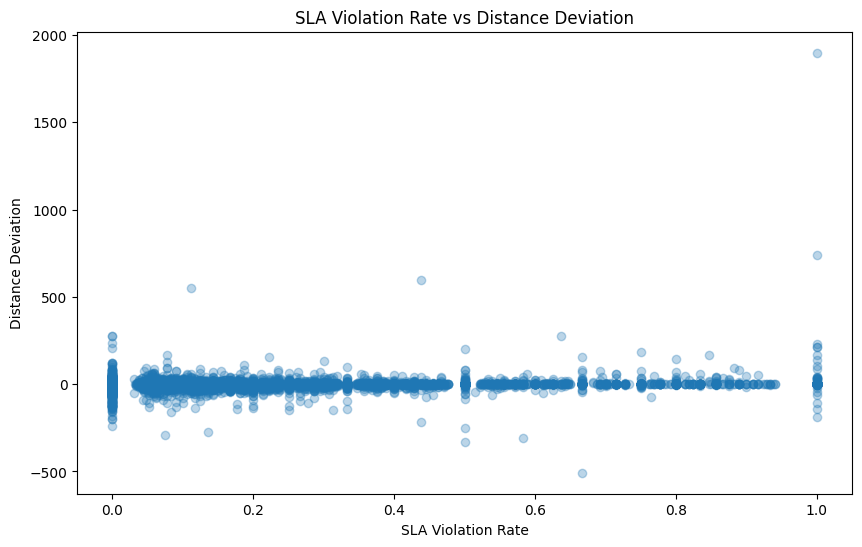

In [35]:
# SLA Violation Rate vs Distance Deviation
plt.figure(figsize=(10,6))
plt.scatter(route_metrics['sla_violation_rate'],route_metrics['distance_deviation'],alpha=0.3)
plt.xlabel('SLA Violation Rate')
plt.ylabel('Distance Deviation')
plt.title('SLA Violation Rate vs Distance Deviation')

Distance deviation alone does not strongly predict SLA violations. Most routes cluster near zero distance deviation across all SLA violation rates, indicating that SLA failures are often driven by factors other than excess distance, such as tight time windows or stop sequencing constraints. While extreme distance deviations can coincide with high SLA violation rates, these cases are rare and represent targeted operational risks rather than a general trend.

In [40]:
route_driver_map =(df[["Route ID", "Driver ID"]].drop_duplicates())
route_metrics = route_metrics.merge(route_driver_map,on="Route ID",how="left")


driver_metrics = (route_metrics.groupby("Driver ID").agg(
        total_routes=("Route ID", "count"),
        avg_distance_deviation=("distance_deviation", "mean"),
        avg_sla_violation_rate=("sla_violation_rate", "mean")
    ).reset_index())



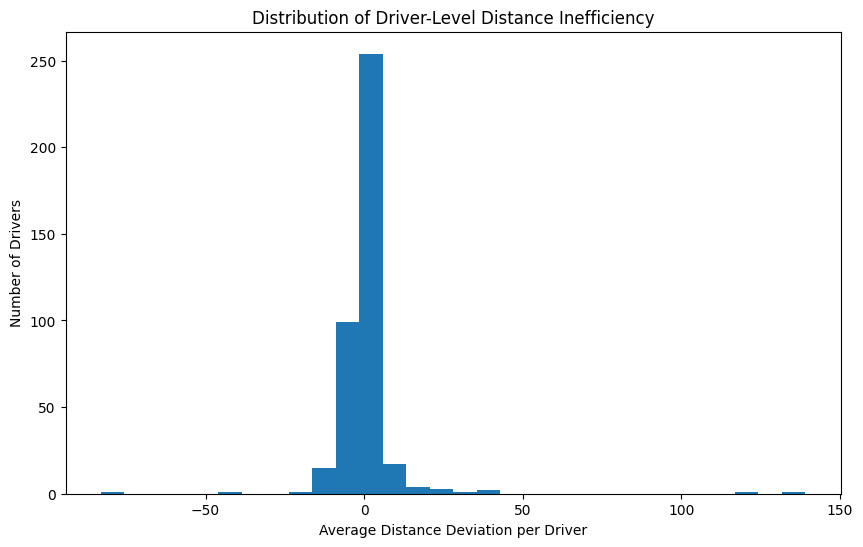

In [41]:
plt.figure(figsize=(10,6))
plt.hist(driver_metrics["avg_distance_deviation"], bins=30)
plt.xlabel("Average Distance Deviation per Driver")
plt.ylabel("Number of Drivers")
plt.title("Distribution of Driver-Level Distance Inefficiency")
plt.show()


Most drivers perform well, but a small group consistently causes high distance loss, so the company should retrain specific drivers instead of changing the rules for everyone.

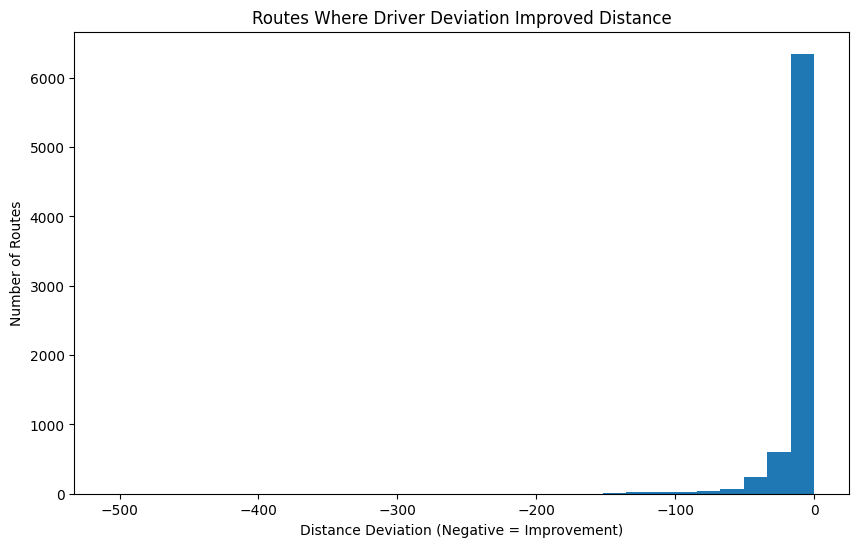

In [45]:
positive_deviation_routes = route_metrics[(route_metrics["distance_deviation"] < 0) &(route_metrics["deviation_rate"] > 0)]
plt.figure(figsize=(10,6))
plt.hist(positive_deviation_routes["distance_deviation"],bins=30)
plt.xlabel("Distance Deviation (Negative = Improvement)")
plt.ylabel("Number of Routes")
plt.title("Routes Where Driver Deviation Improved Distance")
plt.show()


Many routes have a shorter distance when drivers change the stop sequence, which proves that driver intuition sometimes beats the computer's plan. These cases show where the company can improve its routing software by learning from real-world driver behavior.